# Machine Learning Engineer Nanodegree

## Project: Write an Algorithm for Facial Expression Recognition

### PROBLEM STATEMENT

The goal of this project is to predict facial expressions to recognize basic human emotions of anger, disgust, fear, happiness, sadness, surprise, neutralilty. I am using the FER2013 dataset downloaded from Kaggle where there are 35777 images divided into training, validation and test sets. I propose to employ a deep learning technique to learn expressions using the above data set and predict emotions of faces taken from new images with reasonable accuracy.

### PREPROCESSING

The following section will include the following steps:
1. Loading modules
2. Saving images in folders categorized by type of data
3. Preprocessing where grayscale images are normalized by diving pixels by 255.
4. Performing one hot encoding on images


In [1]:
# load the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import cv2
import os
import csv
import argparse
import scipy.misc

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import MaxPool2D
%matplotlib inline

Using TensorFlow backend.
C:\Users\Namita\Anaconda2\envs\dog-project\lib\site-packages\pydot.py:17: UserWarning: Couldn't import dot_parser, loading of dot files will not be possible.
  "Couldn't import dot_parser, "


### Loading the Data

The following code creates 3-channel gray images from FER 2013 dataset. It has been done so that the CNNs designed for RGB images can be used without modifying the input shape. It generates the images and saves them in three directories inside 
the output directory - Training, PublicTest, and PrivateTest. These are the three original splits in the dataset. Further, they are stored by classifying by value of emotion.

The dataset has each datum in the following format:

Emotion | Pixels | Usage
---|:---:|---:


In [2]:
# File and output folder are the below variables.
file = 'fer2013.csv'
output_folder = 'data'

w, h = 48,48
image = np.zeros((h, w), dtype=np.uint8)
id = 1
emotion_list = []
with open(file, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')
    headers = next(reader)
    for row in reader:  
        #fetching emotion from the first column
        emotion = row[0]
        #fetching the pixels of the image
        pixels = np.array(list(map(int, row[1].split())))
        #fetching the usage category of the image - Training/PublicTest/PrivateTest
        usage = row[2]
        
        image = np.reshape(pixels, (w, h))
        image_stack = np.dstack((image,) * 3)
        
        # add emotion to the list
        emotion_list += emotion

        image_folder = os.path.join(output_folder, usage)
        image_folder = os.path.join(image_folder, emotion) 
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        image_file =  os.path.join(image_folder , str(id) + '.jpg')
        scipy.misc.imsave(image_file, image_stack)
        id += 1 
        

np.savetxt("emotions.csv", emotion_list, delimiter=",", fmt='%s')
print("Finished Loading Images!")

Finished Loading Images!


In [3]:
# read images from folder
def load_images():
    # training images (1 - 28709 images)
    images_train = []
    for name in range(28710):
        for emo in range(7):
            img = cv2.imread('data/Training/' + str(emo) + '/'+str(name) + '.jpg', 0)
            if img is not None:
                images_train.append(img)

    # validation images (28710 - 32298 images)
    images_val = []
    for name in range(28710, 32299):
        for emo in range(7):
            img = cv2.imread('data/PublicTest/' + str(emo) + '/'+ str(name) + '.jpg', 0)
            if img is not None:
                images_val.append(img)

    # test images (32299 - 35887 images)
    images_test = []
    for name in range(32299, 35888):
        for emo in range(7):
            img = cv2.imread('data/PrivateTest/' + str(emo) + '/'+ str(name) + '.jpg', 0)
            if img is not None:
                images_test.append(img)

    
    
    return images_train, images_val, images_test

In [4]:
# load the images
images_train, images_val, images_test = load_images()

# change to numpy matrix and normalize pixel values by diving by 255
images_train = np.array(images_train).astype('float32')/255
images_val = np.array(images_val).astype('float32')/255
images_test = np.array(images_test).astype('float32')/255

# save the numpy matrix
np.save('dataset/train_raw.npy', images_train)
np.save('dataset/val_raw.npy', images_val)
np.save('dataset/test_raw.npy', images_test)

In [5]:
# load the images
images_train = np.load('dataset/train_raw.npy')
# load the validation images
images_val = np.load('dataset/val_raw.npy')
# load the test images
images_test = np.load('dataset/test_raw.npy')

In [6]:
# load the corresponding emotion values
emotions = pd.read_csv('emotions.csv', header=None)

### Visualizing The Data

The visualization of distribution of data is presented in this section.

The mapping of value to emotion is below:<br>
0=Angry<br>
1=Disgust<br>
2=Fear<br>
3=Happy<br>
4=Sad<br>
5=Surprise<br>
6=Neutral<br>


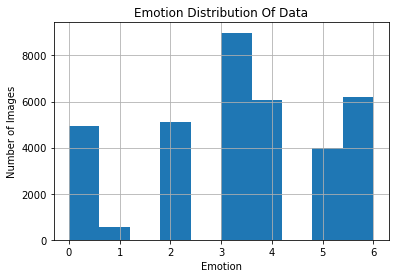

In [7]:
# data distribution of emotions in the images
emotions.hist()
plt.title('Emotion Distribution Of Data')
plt.ylabel('Number of Images')
plt.xlabel('Emotion')

In [8]:
# distribution of images and emotions in terms of counts
emotions[0].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: 0, dtype: int64

In [9]:
# prepare output labels for train, cv and test
y_train = emotions[:images_train.shape[0]].values
y_val = emotions[images_train.shape[0]:images_train.shape[0] + images_val.shape[0]].values
y_test = emotions[images_train.shape[0] + images_val.shape[0]:].values

In [10]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3589, 1)


In [11]:
# create one hot encoding
y_train_encode = to_categorical(y_train, num_classes=7)
y_val_encode = to_categorical(y_val, num_classes=7)
y_test_encode = to_categorical(y_test, num_classes=7)

In [12]:
# checking the shape of the emotion data
print(y_train_encode.shape)
print(y_val_encode.shape)
print(y_test_encode.shape)

(28709, 7)
(3589, 7)
(3589, 7)


In [13]:
# for displaying an image from dataset
def show(img):
    # resize the image
    show_image = img.reshape(48,48)
    # show the image
    plt.imshow(show_image, cmap='gray')

Emotion:[0]


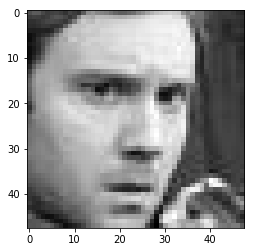

In [14]:
# verify the image with its label
index = 0
# training image
show(images_train[index])
print('Emotion:' + str(y_train[index]))

Emotion:[0]


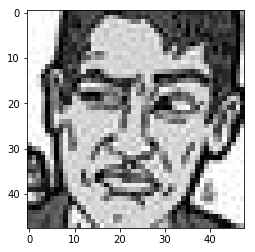

In [15]:
# cv image
show(images_val[index])
print('Emotion:' + str(y_val[index]))

Emotion:[0]


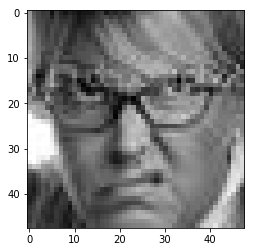

In [16]:
# test image
show(images_test[index])
print('Emotion:' + str(y_test[index]))

In [17]:
# reshape the images for keras model
images_train = np.expand_dims(images_train, 3)
images_val = np.expand_dims(images_val, 3)
images_test = np.expand_dims(images_test, 3)

In [18]:
# checking the shape of the pixel data
print(images_train.shape)
print(images_val.shape)
print(images_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


### SIMPLE MODEL FOR BENCHMARK

This model is provided as a benchmark against which we will provide our solution aiming for better results.


In [19]:
# Simple CNN with Convolutional and MaxPooling layers to provide benchmark results
simple_model = Sequential()

simple_model.add(Conv2D(filters=4, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(48, 48, 1)))
simple_model.add(MaxPooling2D(pool_size=2))
simple_model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
simple_model.add(MaxPooling2D(pool_size=2))
simple_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
simple_model.add(MaxPooling2D(pool_size=2))
simple_model.add(Flatten())
simple_model.add(Dense(7, activation='softmax'))

simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 4)         20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 16)        528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [20]:
# compiling the model
simple_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
#this is the callback function for saving best weights after each epoch
checkpointer = ModelCheckpoint(filepath='model/weights_simple_best.hdf5', 
                               verbose=1, save_best_only=True)

# training the model
simple_model.fit(images_train, y_train_encode, 
          validation_data=(images_val, y_val_encode),
          epochs=3, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 26s - loss: 1.7283 - acc: 0.3084 - val_loss: 1.6256 - val_acc: 0.3728
Epoch 2/3
28709/28709 [==============================] - 22s - loss: 1.5923 - acc: 0.3895 - val_loss: 1.5769 - val_acc: 0.3931
Epoch 3/3
28709/28709 [==============================] - 21s - loss: 1.5421 - acc: 0.4122 - val_loss: 1.5204 - val_acc: 0.4163


In [22]:
# test loss and accuracy
simple_model_score, simple_model_acc = simple_model.evaluate(images_test, y_test_encode, batch_size=32)
print('Test score:', simple_model_score)
print('Test accuracy:', simple_model_acc)

3589/3589 [==============================] - 1s     
Test score: 1.51410644222
Test accuracy: 0.410142100872


### CNN Implementation from Scratch for FER

The following section implements a solution for facial expression recognition using CNN.

The model was derived after trying different layers and parameters. 


In [23]:
# call back function to save the model weights after each epoch if the validation loss decreases
checkpoint = ModelCheckpoint(filepath='model/weights_best.hdf5', verbose=1, save_best_only=True)

In [24]:
model = Sequential()

# 1st stage
model.add(Conv2D(32, 3, input_shape=(48, 48, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# 2nd stage
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# 3rd stage
model.add(Conv2D(128, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# Fully Connected layers
model.add(Flatten())

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7))
model.add(Activation('softmax'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
__________

In [26]:
# compile the model using Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# start training the model with a call to checkpoint at the end of each epoch
hist = model.fit(images_train, y_train_encode, batch_size=128, epochs=5, verbose=1,
          validation_data=(images_val, y_val_encode), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
model.save_weights('model/weights.h5')
model.save('model/model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 1457s - loss: 2.1014 - acc: 0.2424 - val_loss: 1.8439 - val_acc: 0.2494
Epoch 2/5
28709/28709 [==============================] - 1335s - loss: 1.6742 - acc: 0.3556 - val_loss: 1.6784 - val_acc: 0.3514
Epoch 3/5
28709/28709 [==============================] - 1314s - loss: 1.5042 - acc: 0.4179 - val_loss: 1.3919 - val_acc: 0.4611
Epoch 4/5
28709/28709 [==============================] - 1513s - loss: 1.3978 - acc: 0.4606 - val_loss: 1.3286 - val_acc: 0.4907
Epoch 5/5
28709/28709 [==============================] - 1944s - loss: 1.3138 - acc: 0.4958 - val_loss: 1.2640 - val_acc: 0.5063


### Evaluation of Implementation

In [28]:
# training loss and accuracy
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
print('Training Accuracy: ', train_acc[-1])
print('Validation Accuracy: ', val_acc[-1])

# test loss and accuracy
score, acc = model.evaluate(images_test, y_test_encode,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Training Accuracy:  0.495767877686
Validation Accuracy:  0.50626915577
3589/3589 [==============================] - 100s   
Test score: 1.24964060894
Test accuracy: 0.512677626088


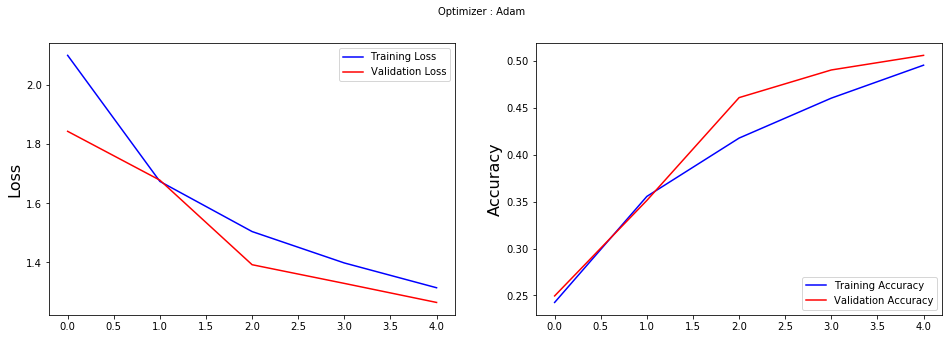

In [29]:
# This code provides visualizations for loss and accuracy

plt.figure(figsize=(16,5))

# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### Refining the Model

The following model is an improvement/refinement on the previous model where I have adjusted/added the parameters. 
e.g. weight initializers have been added in the convolutional layers instead of using random weights as done earlier.
I have also changed the units of layers to train longer and Dropout coefficient to improve performance.

In [37]:
# Refined Model
refined_model = Sequential()

# 1st stage
refined_model.add(Conv2D(64, 3, input_shape=(48, 48, 1), padding='same', activation='relu', 
                         kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(Conv2D(64, 3, padding='same',activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(MaxPool2D(pool_size=(2, 2), strides=2))
refined_model.add(Dropout(0.2))

# 2nd stage
refined_model.add(Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(Conv2D(128, 3, padding='same',activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(MaxPool2D(pool_size=(2, 2), strides=2))
refined_model.add(Dropout(0.2))

# 3rd stage
refined_model.add(Conv2D(256, 3, padding='same',activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='random_uniform'))
refined_model.add(BatchNormalization())
refined_model.add(MaxPool2D(pool_size=(2, 2), strides=2))
refined_model.add(Dropout(0.2))

# Fully Connected layers
refined_model.add(Flatten())
refined_model.add(Dense(256, kernel_initializer='random_uniform'))
refined_model.add(Activation("relu"))
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.2))

refined_model.add(Dense(256, kernel_initializer='random_uniform'))
refined_model.add(Activation("relu"))
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.2))

refined_model.add(Dense(256, kernel_initializer='random_uniform'))
refined_model.add(Activation("relu"))
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.2))

refined_model.add(Dense(7))
refined_model.add(Activation('softmax'))

refined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_20 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [38]:
# compile the model
refined_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# start training the model
refined_hist = refined_model.fit(images_train, y_train_encode, batch_size=128, epochs=9, verbose=1,
          validation_data=(images_val, y_val_encode), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
refined_model.save_weights('model/refined-weights.h5')
refined_model.save('model/refined-model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/9
28709/28709 [==============================] - 4812s - loss: 1.8934 - acc: 0.3117 - val_loss: 1.9694 - val_acc: 0.1886
Epoch 2/9
28709/28709 [==============================] - 3283s - loss: 1.4464 - acc: 0.4467 - val_loss: 1.6506 - val_acc: 0.3564
Epoch 3/9
28709/28709 [==============================] - 3323s - loss: 1.2656 - acc: 0.5202 - val_loss: 1.3329 - val_acc: 0.5032
Epoch 4/9
28709/28709 [==============================] - 3399s - loss: 1.1652 - acc: 0.5578 - val_loss: 1.1810 - val_acc: 0.5528
Epoch 5/9
28709/28709 [==============================] - 3405s - loss: 1.0914 - acc: 0.5889 - val_loss: 1.3945 - val_acc: 0.4739
Epoch 6/9
28709/28709 [==============================] - 4953s - loss: 1.0223 - acc: 0.6135 - val_loss: 1.0966 - val_acc: 0.5910
Epoch 7/9
28709/28709 [==============================] - 3448s - loss: 0.9585 - acc: 0.6419 - val_loss: 1.1979 - val_acc: 0.5690
Epoch 8/9
28709/28709 [=========================

### Evaluating the Refined Model

In [39]:
# training loss and accuracy
train_acc_refined = refined_hist.history['acc']
val_acc_refined = refined_hist.history['val_acc']
print('Training Accuracy: ', train_acc_refined[-1])
print('Validation Accuracy: ', val_acc_refined[-1])

# test loss and accuracy
refined_score, refined_acc = refined_model.evaluate(images_test, y_test_encode, batch_size=32)

print('Test score:', refined_score)
print('Test accuracy:', refined_acc)

Training Accuracy:  0.689923020689
Validation Accuracy:  0.603789356371
3589/3589 [==============================] - 255s   
Test score: 1.09054092774
Test accuracy: 0.611033714143


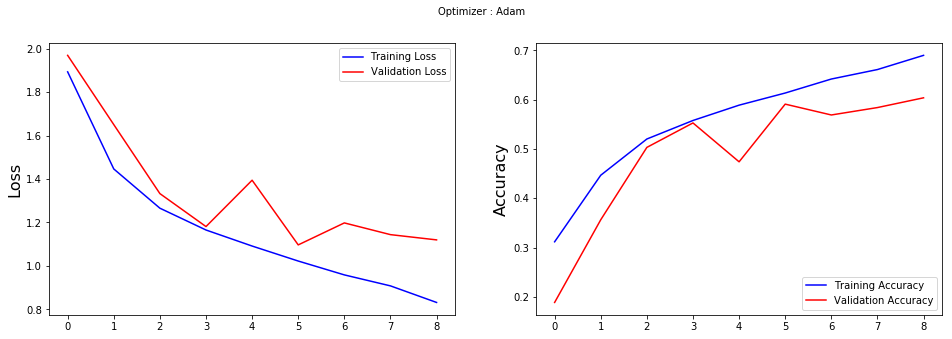

In [40]:
# The below code will present visualizations for loss and accuracy for refined model

plt.figure(figsize=(16,5))

# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(refined_hist.history['loss'], color='b', label='Training Loss')
plt.plot(refined_hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(refined_hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(refined_hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### Testing On External Images

In this part, we load images external to the dataset, and predict the emotion on these.
The images are displayed with the predicted emotion for visual confirmation.


In [51]:
# read images
images = []
for filename in os.listdir('test_images\\'):
    path = os.path.join('test_images\\', filename)
    images.append(cv2.imread(path, -1))

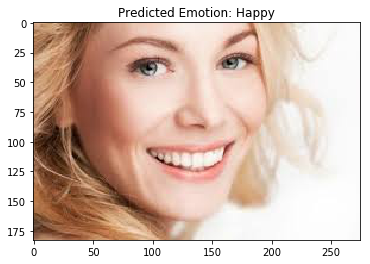

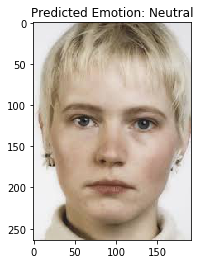

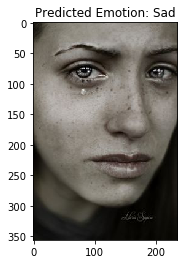

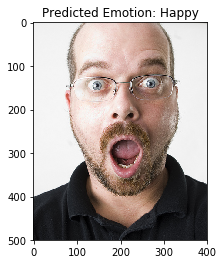

In [52]:
# list of given emotions
EMOTIONS = ['Angry', 'Disgusted', 'Fearful',
            'Happy', 'Sad', 'Surprised', 'Neutral']

# perform prediction on the images after resizing them
for img in images:
    # change to grayscale
    curr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # resize to 48x48 so that it will match the input shape of the model 
    curr_img = cv2.resize(curr_img, (48,48))
    curr_img = np.reshape(curr_img, (1, 48, 48, 1))
    curr_img = np.array(curr_img).astype('float32')/255
    
    # predicting using the refined model
    prediction = np.argmax(refined_model.predict(curr_img))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # to display the predicted emotion and the original image
    plt.imshow(img)
    plt.title('Predicted Emotion: ' + str(EMOTIONS[prediction]))
    plt.show()
    